### Setup

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
latent_dim = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = torchvision.transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)


    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)
    # print(test_loader.dataset.test_data.size())

    # return train_loader, (X_test, y_test)
    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.50MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.9MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.86MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


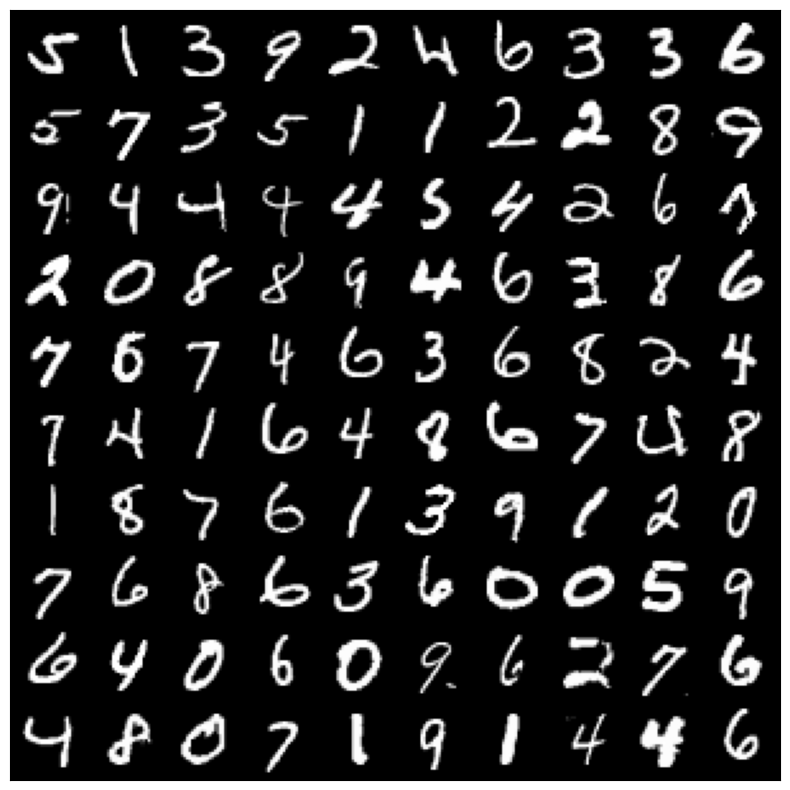

In [3]:
from matplotlib import pyplot as plt

def imshow(img):
    npimg = img.numpy()
    # print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(npimg)
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow = 10))

### Utility Functions

In [4]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    std = torch.exp(0.5 * torch.log(v))
    eps = torch.randn_like(std)
    z = m + std*eps

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

### Base Models

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

In [6]:
class VAE(nn.Module):
    def __init__(self, name = 'vae', z_dim = 2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)


    def loss(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """

        #Forward pass
        m, v = self.enc.encode(x.view(-1, 784))
        z = sample_gaussian(m, v)
        x_r = self.dec.decode(z)

        #KL
        kl = -0.5 * torch.sum(1 + torch.log(v) - m.pow(2) - torch.log(v).exp())

        #Rec
        rec = torch.sum(log_bernoulli_with_logits(x.view(-1, 784), x_r))

        nelbo = 0.01 * (kl + rec)
        return nelbo, kl, rec

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


# Training:

In [7]:
vae = VAE(z_dim = latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
train_loss = []
kl_arr = []
rec_arr = []
for i in tqdm(range(iter_max)):
  vae.train()
  for batch_idx, (xu, _) in enumerate(train_loader):
      xu = xu.to(device)
      optimizer.zero_grad()

      loss, kl, rec = vae.loss(xu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss = np.append(train_loss ,loss.item())
  kl_arr = np.append(kl_arr , kl.item())
  rec_arr = np.append(rec_arr , rec.item())

  2%|▏         | 1/50 [00:19<16:19, 19.99s/it]

Train set loss:121.96322631835938


  4%|▍         | 2/50 [00:36<14:10, 17.72s/it]

Train set loss:116.45079803466797


  6%|▌         | 3/50 [00:52<13:17, 16.98s/it]

Train set loss:113.97479248046875


  8%|▊         | 4/50 [01:08<12:50, 16.74s/it]

Train set loss:110.86630249023438


 10%|█         | 5/50 [01:26<12:47, 17.05s/it]

Train set loss:107.31626892089844


 12%|█▏        | 6/50 [01:42<12:17, 16.77s/it]

Train set loss:114.498046875


 14%|█▍        | 7/50 [01:59<12:07, 16.91s/it]

Train set loss:110.70976257324219


 16%|█▌        | 8/50 [02:24<13:42, 19.58s/it]

Train set loss:106.23894500732422


 18%|█▊        | 9/50 [02:45<13:37, 19.93s/it]

Train set loss:102.07975006103516


 20%|██        | 10/50 [03:08<13:49, 20.73s/it]

Train set loss:107.69015502929688


 22%|██▏       | 11/50 [03:28<13:26, 20.69s/it]

Train set loss:100.80950164794922


 24%|██▍       | 12/50 [03:50<13:19, 21.03s/it]

Train set loss:106.91897583007812


 26%|██▌       | 13/50 [04:11<12:57, 21.02s/it]

Train set loss:104.99876403808594


 28%|██▊       | 14/50 [04:33<12:50, 21.40s/it]

Train set loss:100.57904052734375


 30%|███       | 15/50 [04:54<12:25, 21.31s/it]

Train set loss:101.2944107055664


 32%|███▏      | 16/50 [05:15<11:57, 21.10s/it]

Train set loss:99.4196548461914


 34%|███▍      | 17/50 [05:36<11:37, 21.14s/it]

Train set loss:102.84867095947266


 36%|███▌      | 18/50 [05:53<10:30, 19.70s/it]

Train set loss:101.4362564086914


 38%|███▊      | 19/50 [06:09<09:39, 18.70s/it]

Train set loss:104.21431732177734


 40%|████      | 20/50 [06:26<09:02, 18.07s/it]

Train set loss:100.28112030029297


 42%|████▏     | 21/50 [06:43<08:37, 17.86s/it]

Train set loss:103.01187133789062


 44%|████▍     | 22/50 [06:59<08:05, 17.35s/it]

Train set loss:108.59970092773438


 46%|████▌     | 23/50 [07:15<07:36, 16.91s/it]

Train set loss:99.3330078125


 48%|████▊     | 24/50 [07:31<07:13, 16.66s/it]

Train set loss:98.12152862548828


 50%|█████     | 25/50 [07:48<07:00, 16.83s/it]

Train set loss:106.23106384277344


 52%|█████▏    | 26/50 [08:04<06:39, 16.64s/it]

Train set loss:101.1086196899414


 54%|█████▍    | 27/50 [08:21<06:20, 16.56s/it]

Train set loss:105.02421569824219


 56%|█████▌    | 28/50 [08:37<06:01, 16.45s/it]

Train set loss:97.08527374267578


 58%|█████▊    | 29/50 [08:54<05:46, 16.51s/it]

Train set loss:102.23114776611328


 60%|██████    | 30/50 [09:11<05:33, 16.67s/it]

Train set loss:97.85443878173828


 62%|██████▏   | 31/50 [09:27<05:13, 16.48s/it]

Train set loss:107.58033752441406


 64%|██████▍   | 32/50 [09:43<04:54, 16.37s/it]

Train set loss:103.84476470947266


 66%|██████▌   | 33/50 [09:59<04:36, 16.29s/it]

Train set loss:98.78681182861328


 68%|██████▊   | 34/50 [10:17<04:26, 16.66s/it]

Train set loss:102.50784301757812


 70%|███████   | 35/50 [10:33<04:07, 16.48s/it]

Train set loss:100.72024536132812


 72%|███████▏  | 36/50 [10:49<03:49, 16.36s/it]

Train set loss:103.02971649169922


 74%|███████▍  | 37/50 [11:05<03:31, 16.27s/it]

Train set loss:99.95999908447266


 76%|███████▌  | 38/50 [11:21<03:15, 16.30s/it]

Train set loss:98.94556427001953


 78%|███████▊  | 39/50 [11:38<03:01, 16.52s/it]

Train set loss:99.4076919555664


 80%|████████  | 40/50 [11:54<02:43, 16.36s/it]

Train set loss:101.02976989746094


 82%|████████▏ | 41/50 [12:10<02:26, 16.28s/it]

Train set loss:99.91439056396484


 84%|████████▍ | 42/50 [12:26<02:10, 16.28s/it]

Train set loss:101.24263763427734


 86%|████████▌ | 43/50 [12:44<01:57, 16.75s/it]

Train set loss:104.35781860351562


 88%|████████▊ | 44/50 [13:01<01:39, 16.65s/it]

Train set loss:98.61563873291016


 90%|█████████ | 45/50 [13:17<01:22, 16.53s/it]

Train set loss:100.14944458007812


 92%|█████████▏| 46/50 [13:34<01:06, 16.53s/it]

Train set loss:95.77557373046875


 94%|█████████▍| 47/50 [13:51<00:50, 16.79s/it]

Train set loss:99.27947235107422


 96%|█████████▌| 48/50 [14:08<00:33, 16.78s/it]

Train set loss:101.37611389160156


 98%|█████████▊| 49/50 [14:24<00:16, 16.64s/it]

Train set loss:101.6676025390625


100%|██████████| 50/50 [14:40<00:00, 17.62s/it]

Train set loss:96.017578125


# Train Statistics:

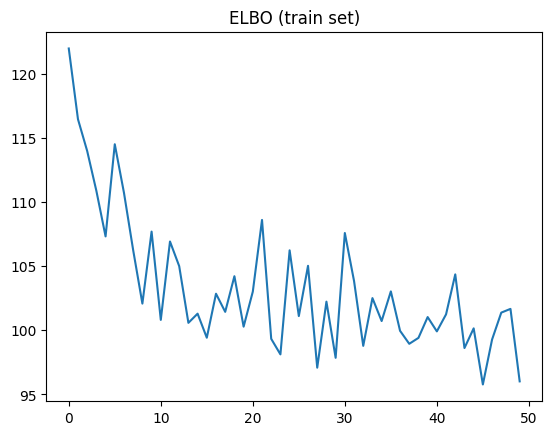

In [8]:
plt.plot(train_loss)
plt.title('ELBO (train set)')
plt.show()

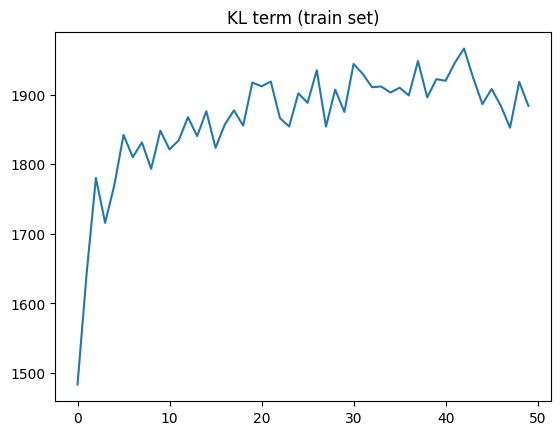

In [9]:
plt.plot(kl_arr)
plt.title('KL term (train set)')
plt.show()

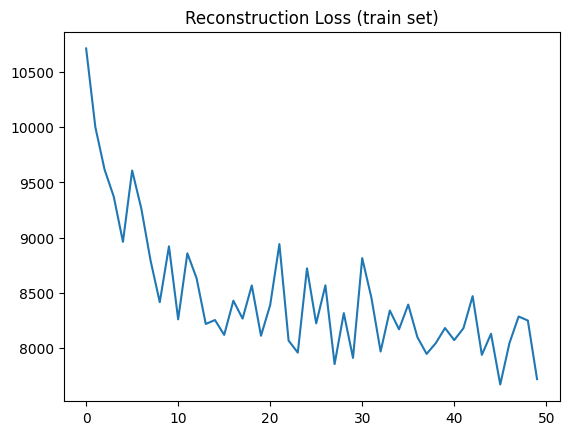

In [10]:
plt.plot(rec_arr)
plt.title('Reconstruction Loss (train set)')
plt.show()

# Testing:

In [11]:
test_loss = []
kl_arr_test = []
rec_arr_test = []
vae.eval()

for i in tqdm(range(iter_max)):
  with torch.no_grad():
      for xu, _ in test_loader:
          xu = xu.to(device)
          tloss, tkl, trec = vae.loss(xu)
      test_loss = np.append(test_loss ,tloss.item())
      kl_arr_test = np.append(kl_arr_test , tkl.item())
      rec_arr_test = np.append(rec_arr_test , trec.item())
      print('Test set loss: {}'.format(tloss))


  2%|▏         | 1/50 [00:02<01:42,  2.10s/it]

Test set loss: 95.49677276611328


  4%|▍         | 2/50 [00:04<02:03,  2.57s/it]

Test set loss: 99.6539306640625


  6%|▌         | 3/50 [00:06<01:43,  2.21s/it]

Test set loss: 100.6553955078125


  8%|▊         | 4/50 [00:08<01:33,  2.04s/it]

Test set loss: 95.97904205322266


 10%|█         | 5/50 [00:10<01:27,  1.95s/it]

Test set loss: 105.40835571289062


 12%|█▏        | 6/50 [00:12<01:23,  1.90s/it]

Test set loss: 103.95819091796875


 14%|█▍        | 7/50 [00:13<01:19,  1.85s/it]

Test set loss: 99.75908660888672


 16%|█▌        | 8/50 [00:16<01:22,  1.97s/it]

Test set loss: 99.76228332519531


 18%|█▊        | 9/50 [00:18<01:30,  2.21s/it]

Test set loss: 103.496337890625


 20%|██        | 10/50 [00:20<01:23,  2.10s/it]

Test set loss: 104.37027740478516


 22%|██▏       | 11/50 [00:22<01:17,  2.00s/it]

Test set loss: 102.79269409179688


 24%|██▍       | 12/50 [00:24<01:13,  1.93s/it]

Test set loss: 99.18293762207031


 26%|██▌       | 13/50 [00:26<01:10,  1.90s/it]

Test set loss: 100.19475555419922


 28%|██▊       | 14/50 [00:27<01:07,  1.87s/it]

Test set loss: 105.0428466796875


 30%|███       | 15/50 [00:30<01:11,  2.03s/it]

Test set loss: 104.31201171875


 32%|███▏      | 16/50 [00:32<01:13,  2.16s/it]

Test set loss: 99.1542739868164


 34%|███▍      | 17/50 [00:34<01:07,  2.04s/it]

Test set loss: 100.851806640625


 36%|███▌      | 18/50 [00:36<01:02,  1.97s/it]

Test set loss: 101.30232238769531


 38%|███▊      | 19/50 [00:38<00:58,  1.90s/it]

Test set loss: 101.56871032714844


 40%|████      | 20/50 [00:39<00:56,  1.87s/it]

Test set loss: 102.3113784790039


 42%|████▏     | 21/50 [00:41<00:53,  1.84s/it]

Test set loss: 100.61503601074219


 44%|████▍     | 22/50 [00:44<00:58,  2.09s/it]

Test set loss: 100.2858657836914


 46%|████▌     | 23/50 [00:46<00:57,  2.14s/it]

Test set loss: 95.17015075683594


 48%|████▊     | 24/50 [00:48<00:52,  2.02s/it]

Test set loss: 97.72718811035156


 50%|█████     | 25/50 [00:50<00:49,  1.97s/it]

Test set loss: 104.27261352539062


 52%|█████▏    | 26/50 [00:51<00:45,  1.91s/it]

Test set loss: 102.0802230834961


 54%|█████▍    | 27/50 [00:53<00:42,  1.87s/it]

Test set loss: 98.36447143554688


 56%|█████▌    | 28/50 [00:55<00:40,  1.85s/it]

Test set loss: 95.52095794677734


 58%|█████▊    | 29/50 [00:58<00:44,  2.14s/it]

Test set loss: 98.20796966552734


 60%|██████    | 30/50 [01:00<00:42,  2.11s/it]

Test set loss: 102.28205108642578


 62%|██████▏   | 31/50 [01:02<00:38,  2.00s/it]

Test set loss: 105.32869720458984


 64%|██████▍   | 32/50 [01:03<00:34,  1.94s/it]

Test set loss: 99.31376647949219


 66%|██████▌   | 33/50 [01:05<00:32,  1.89s/it]

Test set loss: 101.16124725341797


 68%|██████▊   | 34/50 [01:07<00:29,  1.86s/it]

Test set loss: 99.9344482421875


 70%|███████   | 35/50 [01:09<00:28,  1.90s/it]

Test set loss: 103.52572631835938


 72%|███████▏  | 36/50 [01:12<00:31,  2.22s/it]

Test set loss: 100.15113067626953


 74%|███████▍  | 37/50 [01:14<00:27,  2.09s/it]

Test set loss: 97.63191986083984


 76%|███████▌  | 38/50 [01:16<00:24,  2.01s/it]

Test set loss: 101.50042724609375


 78%|███████▊  | 39/50 [01:17<00:21,  1.94s/it]

Test set loss: 102.9245376586914


 80%|████████  | 40/50 [01:19<00:18,  1.89s/it]

Test set loss: 98.9286880493164


 82%|████████▏ | 41/50 [01:21<00:16,  1.87s/it]

Test set loss: 102.72537231445312


 84%|████████▍ | 42/50 [01:23<00:16,  2.01s/it]

Test set loss: 107.48939514160156


 86%|████████▌ | 43/50 [01:26<00:15,  2.15s/it]

Test set loss: 97.04932403564453


 88%|████████▊ | 44/50 [01:27<00:12,  2.03s/it]

Test set loss: 104.07748413085938


 90%|█████████ | 45/50 [01:29<00:09,  1.96s/it]

Test set loss: 103.94438934326172


 92%|█████████▏| 46/50 [01:31<00:07,  1.89s/it]

Test set loss: 103.5340805053711


 94%|█████████▍| 47/50 [01:33<00:05,  1.88s/it]

Test set loss: 102.16458129882812


 96%|█████████▌| 48/50 [01:35<00:03,  1.86s/it]

Test set loss: 100.43888092041016


 98%|█████████▊| 49/50 [01:37<00:02,  2.09s/it]

Test set loss: 99.59842681884766


100%|██████████| 50/50 [01:40<00:00,  2.00s/it]

Test set loss: 105.4405517578125


# Test Statistics:

(50,)


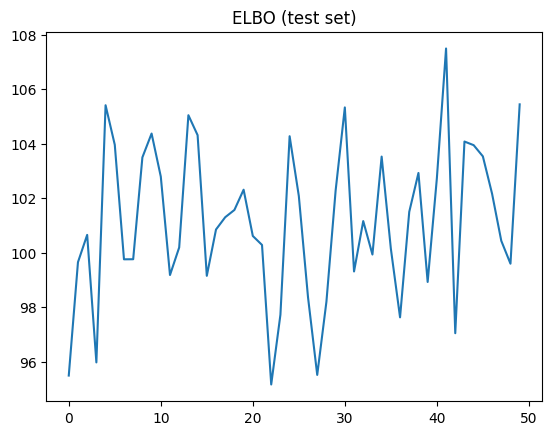

In [12]:
print(test_loss.shape)
plt.plot(test_loss)
plt.title('ELBO (test set)')
plt.show()

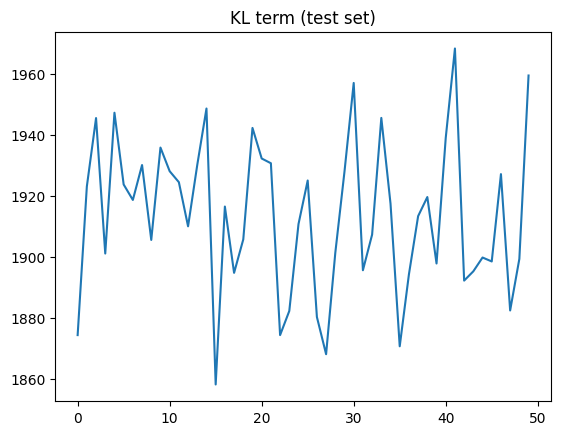

In [13]:
plt.plot(kl_arr_test)
plt.title('KL term (test set)')
plt.show()

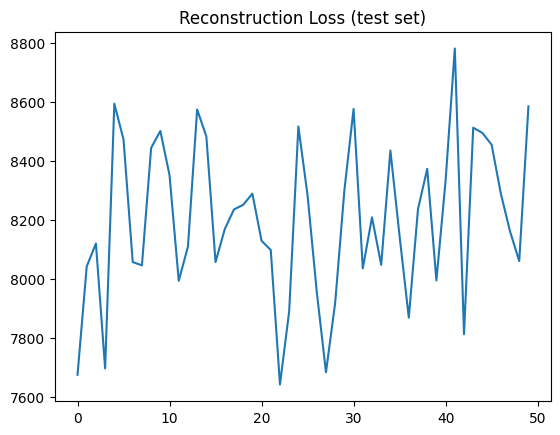

In [14]:
plt.plot(rec_arr_test)
plt.title('Reconstruction Loss (test set)')
plt.show()

# Generating 100 MNIST numbers:

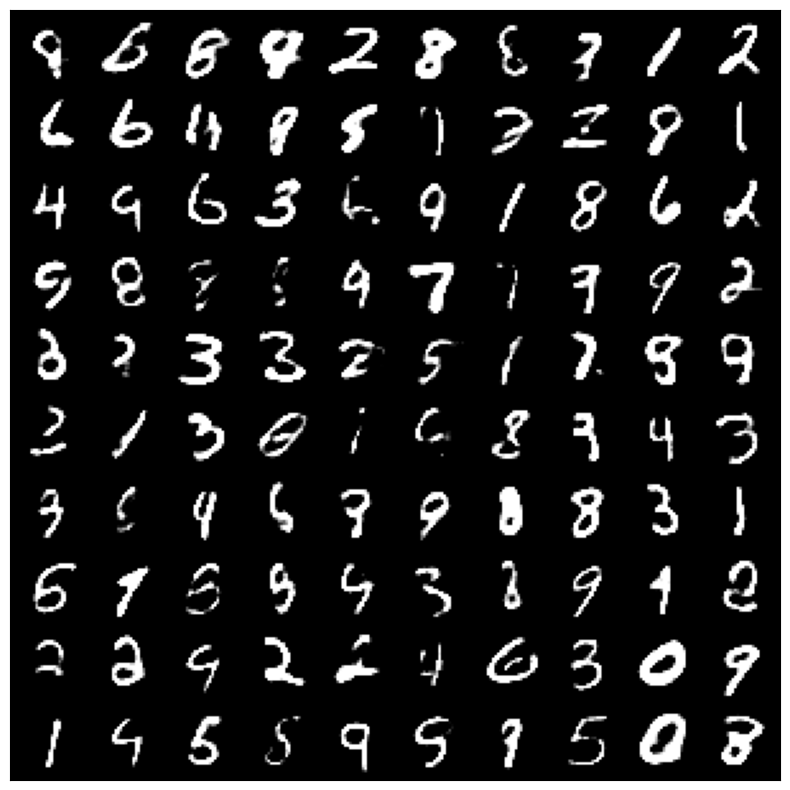

In [19]:
with torch.no_grad():
    z = torch.randn(100, 10).to(device)
    sample = vae.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))
    # torchvision.utils.save_image(sample.view(100, 1, 28, 28), './sample_' + '.png')
